In [1]:
from prometheus_api_client import PrometheusConnect, MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime
import pandas as pd
import pendulum
from greenflow.g import g
from tinydb import TinyDB, Query
from os import getenv

url = getenv("PROMETHEUS_URL")
prom = PrometheusConnect(url=url)


In [2]:
experiments = {exp.doc_id: exp for exp in g.storage.experiments.all()}

def sort_by_time(exp_id):
    date_time_str = experiments[exp_id]["started_ts"]
    return pendulum.parse(date_time_str)

In [3]:
exp_ids = sorted(
    experiments.keys(),
    key=sort_by_time,
    reverse=True,
)
results = []

for index, _ in enumerate(exp_ids):
    current = exp_ids[index]
    started_ts_string = experiments[current]["started_ts"]
    stopped_ts_string = experiments[current]["stopped_ts"]
    started_ts = pendulum.parse(started_ts_string)
    stopped_ts = pendulum.parse(stopped_ts_string)
    metadata = experiments[current]["experiment_metadata"]
    params = dict(**metadata["factors"]["exp_params"])
    # select just the relevant params - load, instances, durationSeconds
    params = {
        k: v for k, v in params.items() if k in ["load", "instances", "durationSeconds"]
    }
    if "results" in metadata:
        result = metadata["results"]
    else:
        result = {}
    current_result = {
        "exp_id": current,
        "exp_name": experiments[current]["exp_name"],
        "started_ts": started_ts_string,
        "stopped_ts": stopped_ts_string,
        "duration_from_ts": stopped_ts.diff(started_ts).in_seconds(),
        "dashboard_url": metadata["dashboard_url"],
        **result,
        **params,
    }

    if started_ts > pendulum.now().subtract(days=3):
        results.append(current_result)

results = pd.DataFrame(results)
# Reindex with exp_id
results = results.set_index("exp_id")
# print(results[:25].to_csv())
redpanda_kafka_data = results

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in the 'redpanda_kafka_data' DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid

# Filter out start and stop times
# redpanda_kafka_data = redpanda_kafka_data.drop(columns=['started_ts', 'stopped_ts'])
redpanda_kafka_data['load'] = pd.to_numeric(redpanda_kafka_data['load'], errors='coerce')
redpanda_kafka_data['total_host_energy'] = pd.to_numeric(redpanda_kafka_data['total_host_energy'], errors='coerce')

# Display DataFrame using qgrid (Assuming your DataFrame is 'redpanda_kafka_data')
qgrid_widget = qgrid.show_grid(redpanda_kafka_data, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

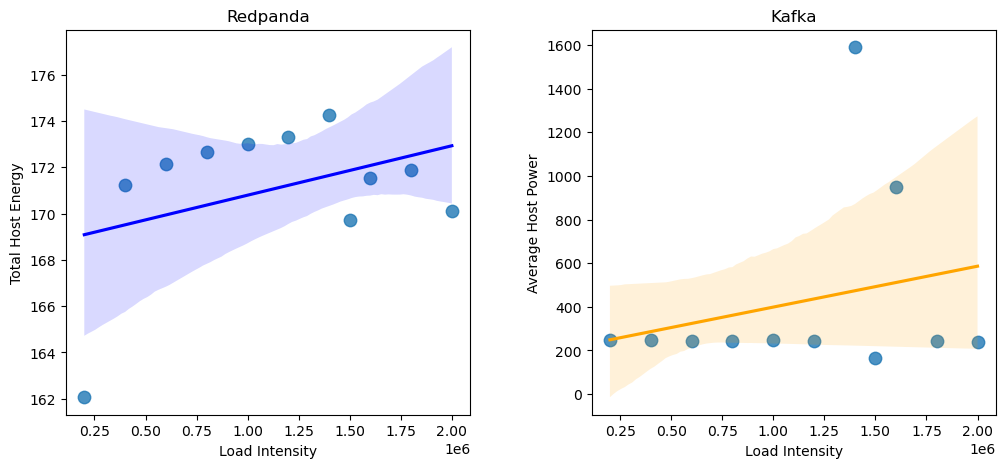

In [ ]:
redpanda_kafka_data = qgrid_widget.get_changed_df()
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Redpanda data on the first subplot
sns.regplot(x='load', y='avg_host_power', data=redpanda_kafka_data[redpanda_kafka_data['exp_name'] == 'ingest-redpanda'], 
            ax=ax1, scatter_kws={'s': 80}, line_kws={'color': 'blue'})
ax1.set_title('Redpanda')
ax1.set_xlabel('Load Intensity')
ax1.set_ylabel('Total Host Energy')

# Plot Kafka data on the second subplot
sns.regplot(x='load', y='avg_host_power', data=redpanda_kafka_data[redpanda_kafka_data['exp_name'] == 'ingest-kafka'],
            ax=ax2, scatter_kws={'s': 80}, line_kws={'color': 'orange'})
ax2.set_title('Kafka')
ax2.set_xlabel('Load Intensity')
ax2.set_ylabel('Average Host Power')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

In [ ]:

experiments = prom.get_label_values("experiment_started_ts", params={"start":pendulum.now().subtract(hours=96).to_iso8601_string(), "match[]": f'up{{deployment_started_ts="{deployments[index][1]}"}}'})
experiments = sorted(
    list(map(lambda x: (pendulum.parse(x, strict=False), x), experiments)), reverse=True
)

results = []

for index, (chosen_dt, chosen_ts) in enumerate(experiments):
    try:
        data = MetricRangeDataFrame(prom.get_metric_range_data(
            f'scaph_host_energy_microjoules{{experiment_started_ts="{chosen_ts}"}}',
            start_time=chosen_dt.subtract(minutes=10),
            end_time=chosen_dt.add(minutes=10),
        ))
    except Exception as e:
        print(index, chosen_ts, chosen_dt)
        continue
    grouped_max = data.groupby('instance')['value'].max()
    grouped_min = data.groupby('instance')['value'].min()
    joules = sum(grouped_max - grouped_min) / 10**6
    results.append({'experiment_ts': chosen_ts, 'Joules Consumed': joules})

df_results = pd.DataFrame(results)
df_results


TypeError: cannot unpack non-iterable int object

In [ ]:
def calculate_results():
    from os import getenv
    url = getenv("PROMETHEUS_URL")
    started_ts = pendulum.parse('2024-03-19T04:08:09.268325+01:00')
    stopped_ts = pendulum.parse('2024-03-19T04:13:41.118932+01:00')
    results = {}

    prom = PrometheusConnect(url=url)
    data = MetricRangeDataFrame(prom.get_metric_range_data(
        f'scaph_host_energy_microjoules{{experiment_started_ts="2024-03-19T04:08:09.268325+01:00"}}',
        start_time=started_ts.subtract(hours=96),
        end_time=started_ts.add(hours=96),
    ))
    grouped_max = data.groupby('instance')['value'].max()
    grouped_min = data.groupby('instance')['value'].min()
    joules = sum(grouped_max - grouped_min) / 10**6

    duration = stopped_ts.diff(started_ts).seconds
    results["duration"] = duration
    results["total_host_energy"] = joules
    results["avg_host_power"] = joules / duration
    print(results)

calculate_results()

{'duration': 331, 'total_host_energy': 75763.008608, 'avg_host_power': 228.89126467673717}


In [ ]:
df2 = pd.read_json(f'https://api.grid5000.fr/stable/sites/lyon/metrics?job_id={job_id}')
df2 = df2.drop(df2[df2['metric_id']!='wattmetre_power_watt'].index)
df2 = df2.drop(df2[df2['device_id']!='taurus-15'].index)
df2.loc[df2.device_id == 'taurus-15', 'device_id'] = 'taurus-15.lyon.grid5000.fr'

In [ ]:
df2 = df2.set_index('timestamp')

In [ ]:
index = 43
chosen_ts = deployments[index][1]
chosen_dt = deployments[index][0]
data = MetricRangeDataFrame(prom.get_metric_range_data(
    f'scaph_host_energy_microjoules{{experiment_started_ts="{chosen_ts}"}}',  # this is the metric name and label config
    start_time=chosen_dt,
    end_time=chosen_dt.add(minutes=10),
    # step=1
))
# Group by instance
grouped_max = data.groupby('instance')['value'].max()
grouped_min = data.groupby('instance')['value'].min()

print(sum(grouped_max - grouped_min)/10**6, "Joules")

38720.961583 Joules


In [ ]:
df2 = df2.drop(['device_id', 'metric_id', 'labels'], axis=1)
df2

,value
timestamp,
2022-08-16 16:20:17+02:00,115.146667
2022-08-16 16:20:18+02:00,102.845455
2022-08-16 16:20:19+02:00,116.206977
2022-08-16 16:20:20+02:00,94.302500
2022-08-16 16:20:21+02:00,88.193023
...,...
2022-08-16 17:46:25+02:00,102.194286
2022-08-16 17:46:26+02:00,110.740909
2022-08-16 17:46:27+02:00,103.710638


In [ ]:

df2 = df2[df2.index >= '2022-08-16 16:26:20+02:00'].asfreq('5S')
df2

,value
timestamp,
2022-08-16 16:26:20+02:00,94.690244
2022-08-16 16:26:25+02:00,95.346154
2022-08-16 16:26:30+02:00,95.597222
2022-08-16 16:26:35+02:00,100.394737
2022-08-16 16:26:40+02:00,96.415385
...,...
2022-08-16 17:46:05+02:00,104.211905
2022-08-16 17:46:10+02:00,96.310256
2022-08-16 17:46:15+02:00,101.313158


In [ ]:
import seaborn as sb
# df3 = df2-df
df3
df2.index.dtype
df.index = pd.to_datetime(df.index).tz_convert('Etc/UTC')
# df2.index = pd.to_datetime(df2.index).tz_convert('Etc/UTC')
# sb.lineplot(data=df)
# sb.lineplot(data=df2)
# sb.lineplot(data=df3)
df
df2 = df2.drop(df2[df2.index > '2022-08-16 15:45:50+00:00'].index)
df2

,wattmetre
timestamp,
2022-08-16 16:26:20+02:00,94.690244
2022-08-16 16:26:25+02:00,95.346154
2022-08-16 16:26:30+02:00,95.597222
2022-08-16 16:26:35+02:00,100.394737
2022-08-16 16:26:40+02:00,96.415385
...,...
2022-08-16 17:45:30+02:00,95.465714
2022-08-16 17:45:35+02:00,98.615000
2022-08-16 17:45:40+02:00,96.148718


          wattmetre
count  9.550000e+02
mean   1.262980e-15
std    1.000000e+00
min   -1.510736e+00
25%   -6.446656e-01
50%   -2.298831e-01
75%    3.430783e-01
max    5.266216e+00
              scaph
count  9.530000e+02
mean   6.672988e-16
std    1.000000e+00
min   -1.820495e+00
25%   -6.977096e-01
50%   -1.957109e-01
75%    4.390120e-01
max    4.371471e+00


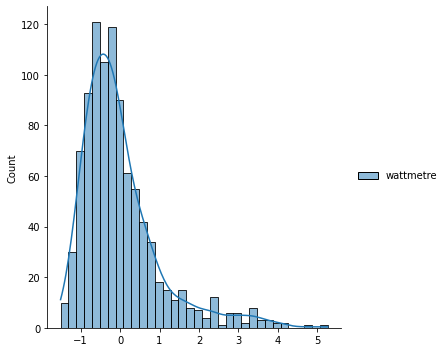

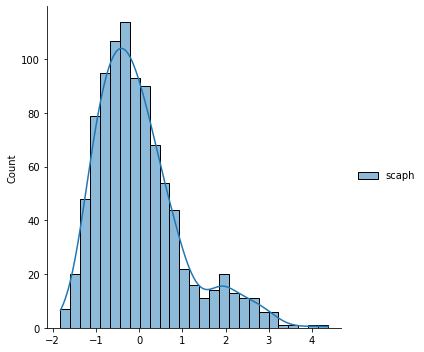

In [ ]:
df = df.rename(columns={'value': 'scaph'})
df_norm = (df-df.mean())/df.std()
df2 = df2.rename(columns={'value': 'wattmetre'})
df2_norm = (df2-df2.mean())/df2.std()
print(df2_norm.describe())
print(df_norm.describe())
# print(df.describe())
# print(df2.describe())
# df3 = df.join(df2)
# df3.corr()
# df3
# df3 = pd.merge_ordered(df, df2)
# df3=  df3.dropna()
# df3 = df3 - df3.mean()
# df3.describe()
# # sb.scatterplot(data=df3, ci='sd')
sb.displot(data=df2_norm, kde=True)
sb.displot(data=df_norm, kde=True)